# Experiment Template

**Team Member:** [Your Name]  
**Model:** [e.g., RNN, LSTM, GRU, Logistic Regression]  
**Embedding:** [e.g., TF-IDF, Word2Vec (Skip-gram), GloVe]

---

## 1. Setup & Imports

In [30]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.9 MB/s eta 0:00:00


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set plot style
sns.set(style="whitegrid")

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load Data

In [19]:
DATA_PATH = '/content/drive/MyDrive/data/IMDB Dataset.csv'
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Please ensure the dataset is in the data folder.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully: {df.shape}")
    display(df.head())

Dataset loaded successfully: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Exploratory Data Analysis (EDA)
Understanding the dataset characteristics.

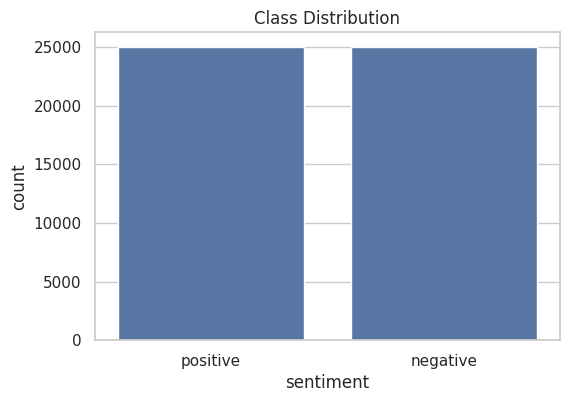

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [20]:
if 'sentiment' in df.columns:
    # Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df)
    plt.title('Class Distribution')
    plt.show()
    print(df['sentiment'].value_counts())

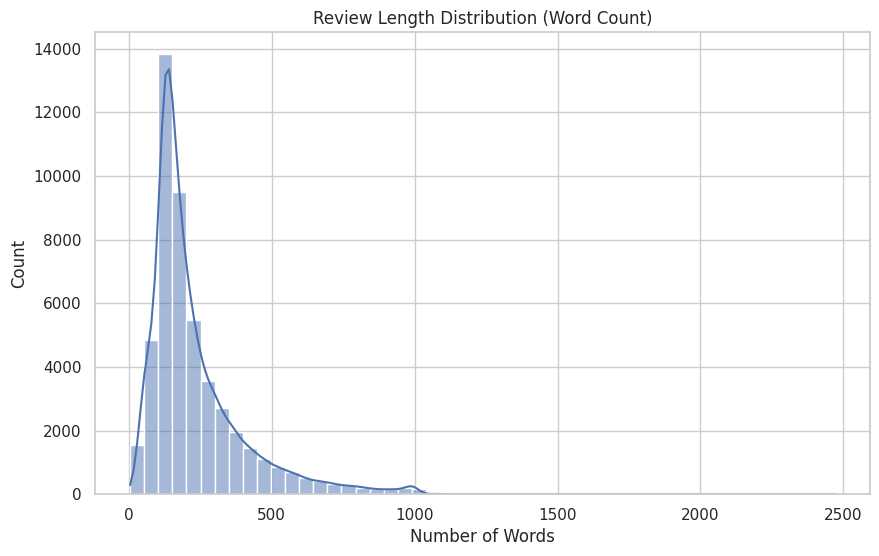

Average word count: 231.16


In [21]:
# Review Length Analysis
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean():.2f}")

## 4. Preprocessing
Applying shared preprocessing strategy:
1. Lowercase
2. Remove HTML tags
3. Remove special characters
4. Tokenize
5. Remove stopwords (Optional based on embedding)

In [22]:
def clean_text(text, remove_stopwords=True):
    # 1. Lowercase
    text = text.lower()
    # 2. HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove non-alphanumeric characters (preserving spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords (Optional based on embedding)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)
    else:
        return " ".join(tokens)

# Apply cleaning (Default strategy)
print("Preprocessing data (this may take a moment)...")
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x, remove_stopwords=True))
display(df[['review', 'cleaned_review']].head())

Preprocessing data (this may take a moment)...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Post-Preprocessing Visualization

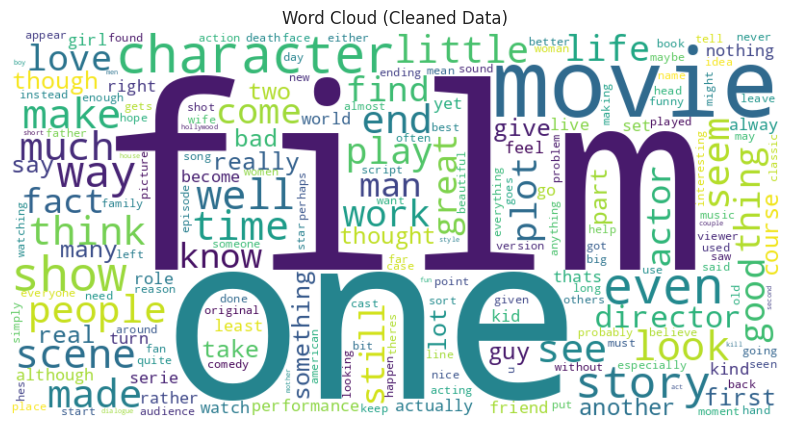

In [23]:
# Word Cloud for cleaned text
all_text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Data)')
plt.show()

In [27]:
# Train/Test Split
X = df['cleaned_review'].values
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values # Binary encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


In [28]:
# Initialize Vectorizer
tfidf_vec = TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1,2))

# Transform data
X_train_emb = tfidf_vec.fit_transform(X_train).toarray()
X_test_emb = tfidf_vec.transform(X_test).toarray()

print(f"TF-IDF Shape: {X_train_emb.shape}")

TF-IDF Shape: (40000, 5000)


In [32]:
# Tokenize for Gensim
train_tokens = [s.split() for s in X_train]
test_tokens = [s.split() for s in X_test]

# Train Skip-gram (sg=1)
w2v_sg_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=1, min_count=2)

def get_mean_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in test_tokens])

print(f"Skip-gram Shape: {X_train_emb.shape}")

Skip-gram Shape: (40000, 100)


In [33]:
# Train CBOW (sg=0)
w2v_cbow_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=0, min_count=2)

X_train_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in test_tokens])

print(f"CBOW Shape: {X_train_emb.shape}")

CBOW Shape: (40000, 100)


## 5. Embedding Layer
Implement your specific embedding here (TF-IDF, Skip-gram (Word2Vec) and CBOW (Word2Vec)).

In [ ]:
# TODO: Implement Embedding
# Example for Word2Vec/Glove: Prepare Tokenizer and Embedding Matrix
# Example for TF-IDF: Use TfidfVectorizer

pass

## 6. Model Architecture
Define your model (RNN, LSTM, GRU, or Traditional ML).

In [ ]:
# TODO: Define Model
model = None

## 7. Training

In [ ]:
# TODO: Train model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

## 8. Evaluation

In [ ]:
# TODO: Evaluate
# y_pred = model.predict(X_test)
# y_pred_class = (y_pred > 0.5).astype(int)

# print("Accuracy:", accuracy_score(y_test, y_pred_class))
# print(classification_report(y_test, y_pred_class))

# Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_class)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

## 9. Save Results

In [ ]:
# results = {
#     'model': 'MyModel',
#     'embedding': 'MyEmbedding',
#     'accuracy': 0.0
# }
# result_df = pd.DataFrame([results])
# result_df.to_csv('../results/experiment_results.csv', mode='a', header=not os.path.exists('../results/experiment_results.csv'), index=False)